In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = trp
band = 4
commitnumber = d62b618
conc = 0.0004
dv = 0.005
klin = 0
molecule = co2
ng_adju = [0, 0]
ng_refs = [8, 8]
nv = 200
option_compute_btable = 0
option_compute_ktable = 0
option_wgt_flux = 1
option_wgt_k = 1
ref_pts = [(1, 250), (500, 250)]
tsfc = 300
vmax = 980
vmin = 800
w_diffuse = [(1.66, 1.66, 1.66, 1.66, 1.66, 1.66, 1.66, 1.66), (1.66, 1.66, 1.66, 1.66, 1.66, 1.66, 1.66, 1.66)]
wgt = [(1, 1, 1, 1, 1, 1, 1, 1), (1, 1, 1, 1, 1, 1, 1, 1)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

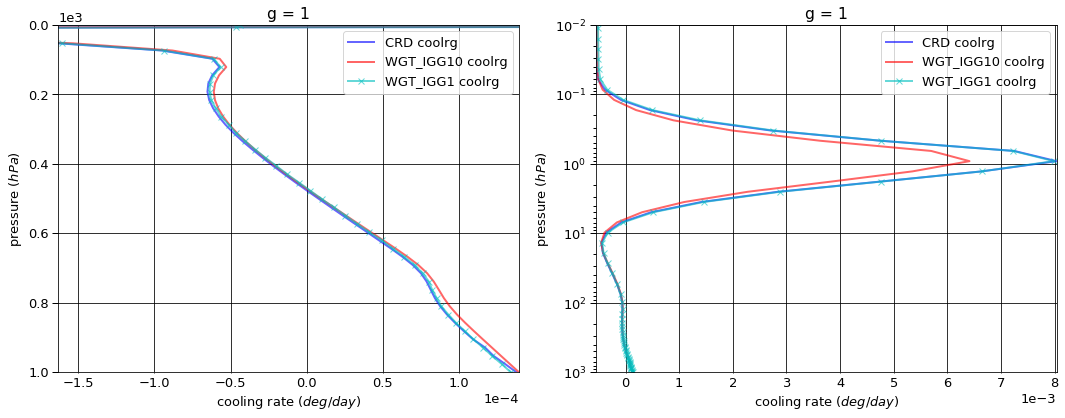

# Figure: cooling rate g-group 2

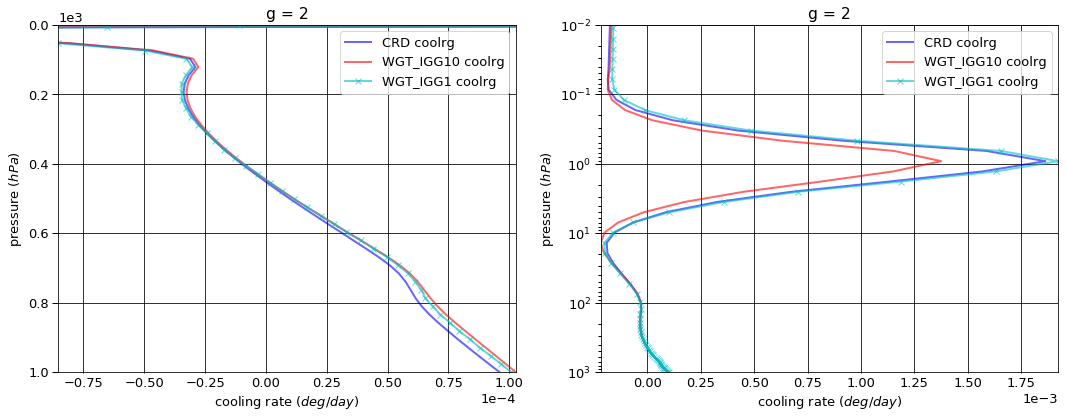

# Figure: cooling rate g-group 3

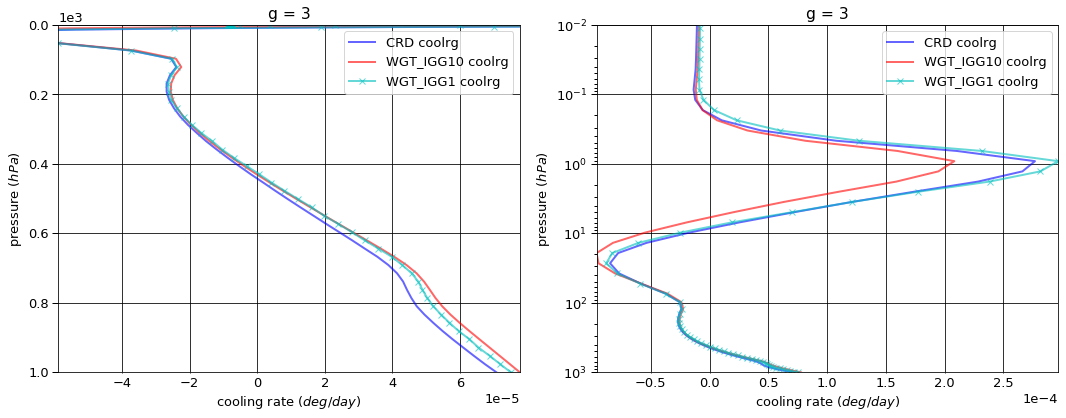

# Figure: cooling rate g-group 4

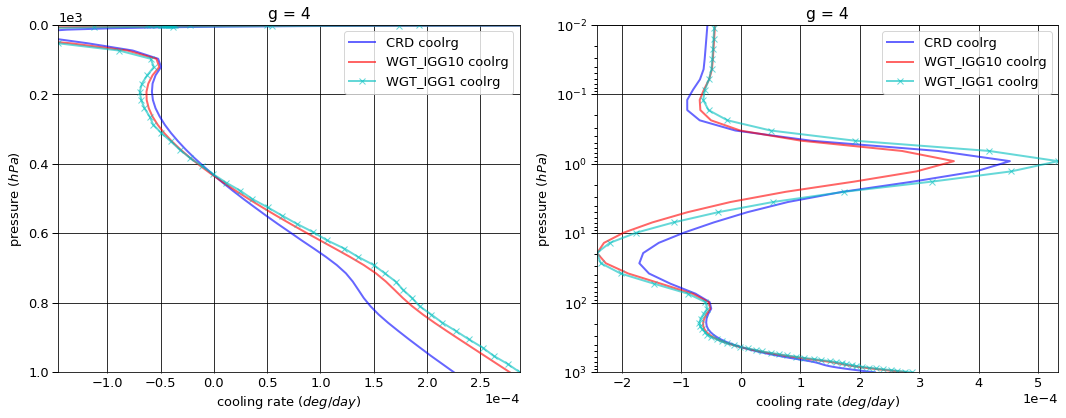

# Figure: cooling rate g-group 5

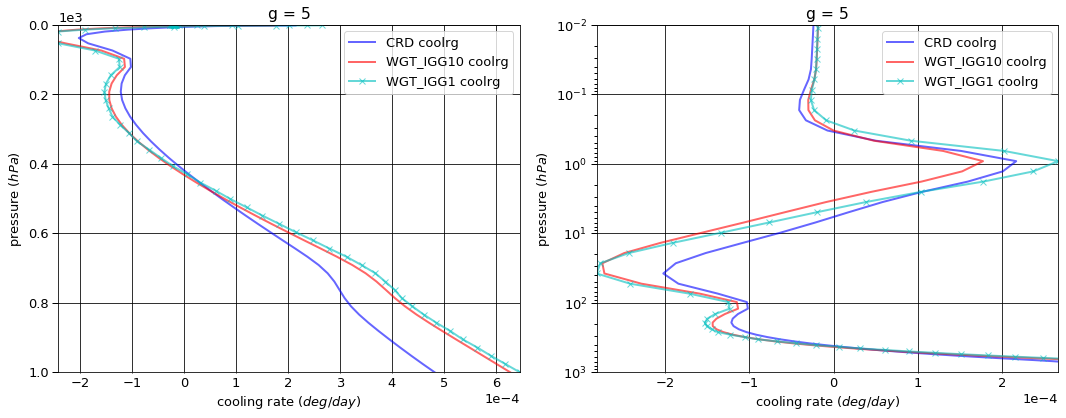

# Figure: cooling rate g-group 6

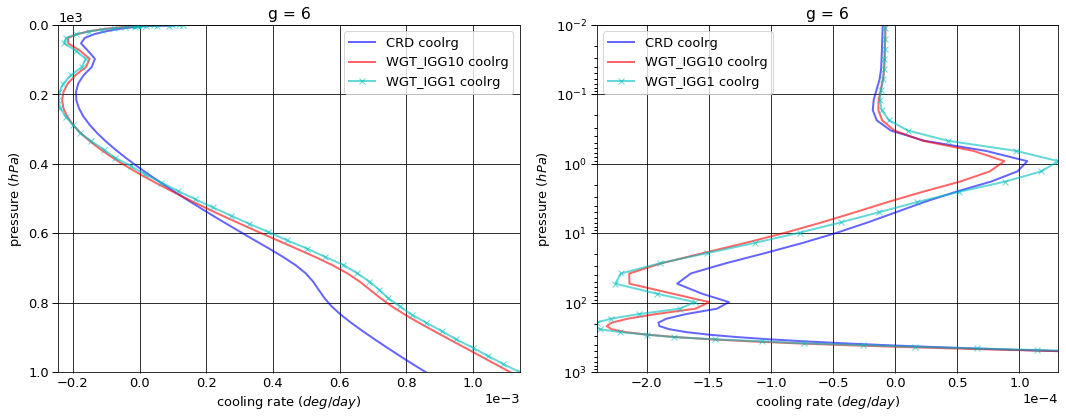

# Figure: cooling rate g-group 7

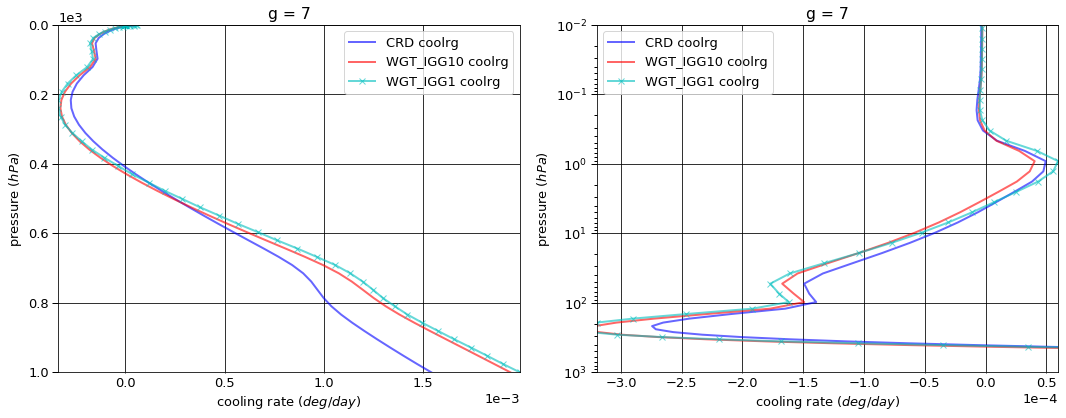

# Figure: cooling rate g-group 8

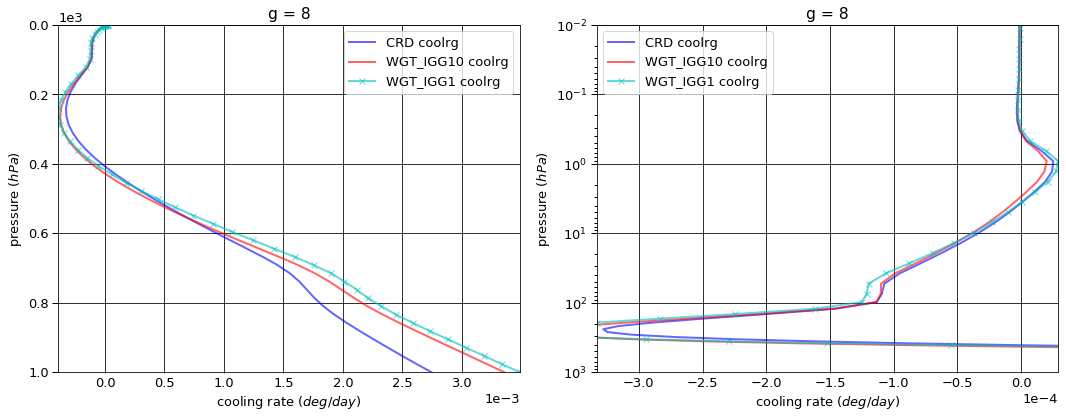

# Figure: cooling rate g-group 9

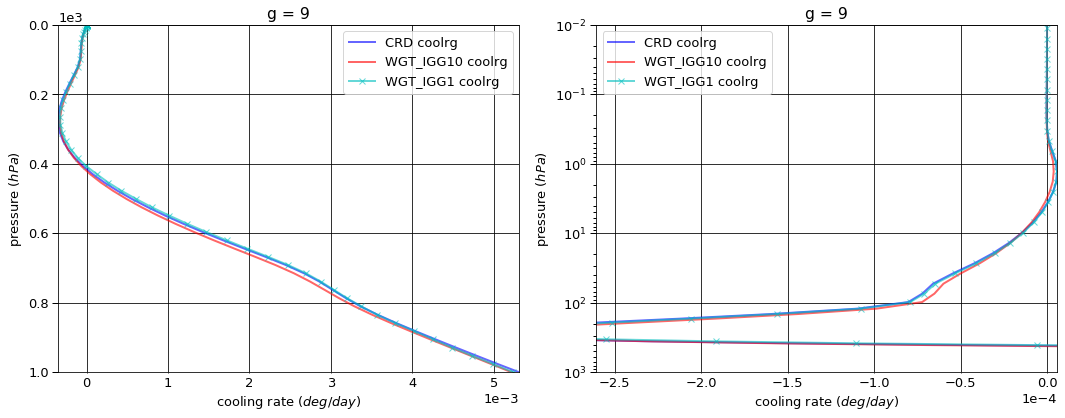

# Figure: cooling rate g-group 10

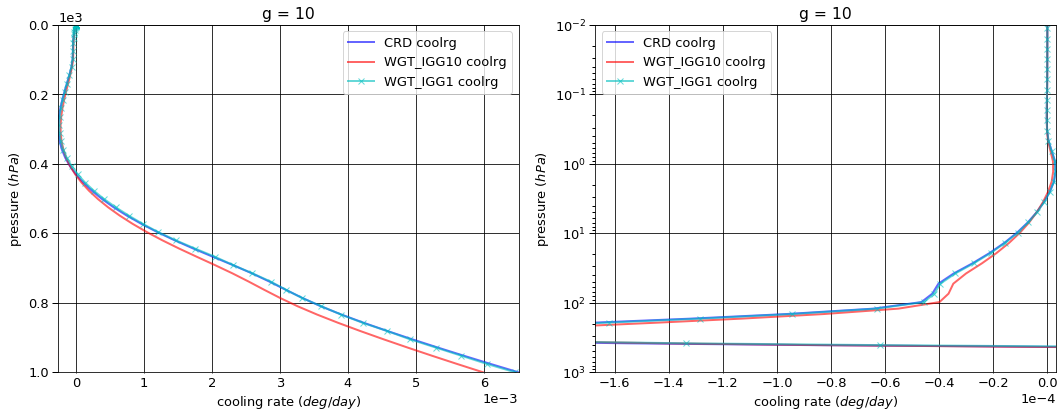

# Figure: cooling rate g-group 11

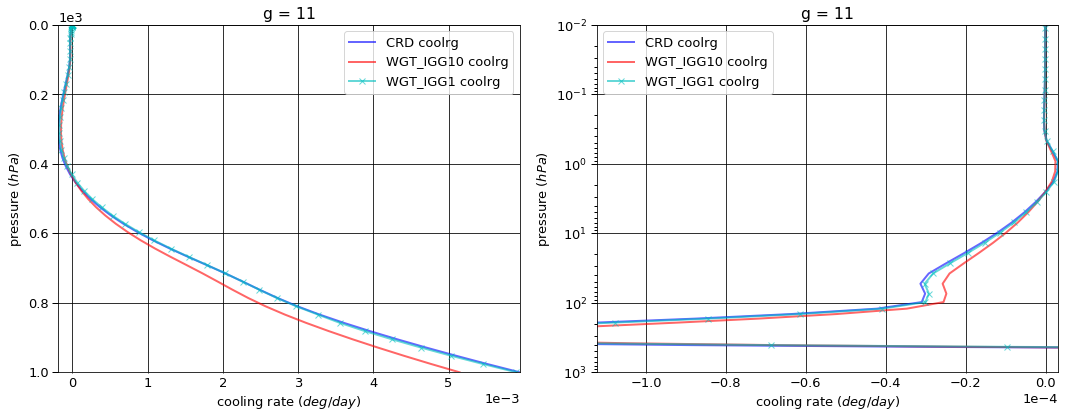

# Figure: cooling rate g-group 12

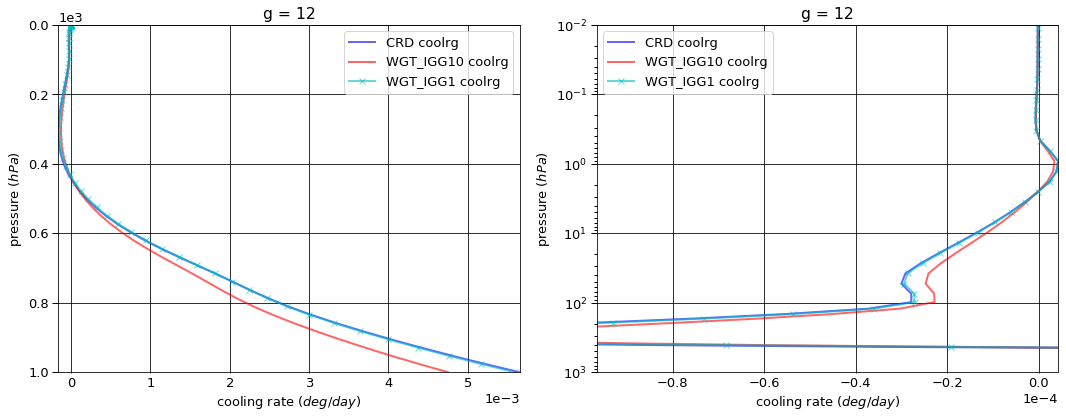

# Figure: cooling rate g-group 13

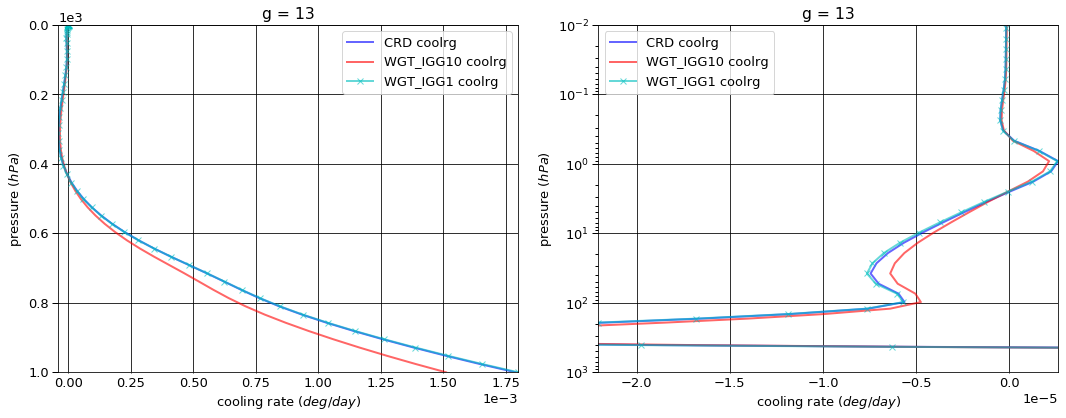

# Figure: cooling rate g-group 14

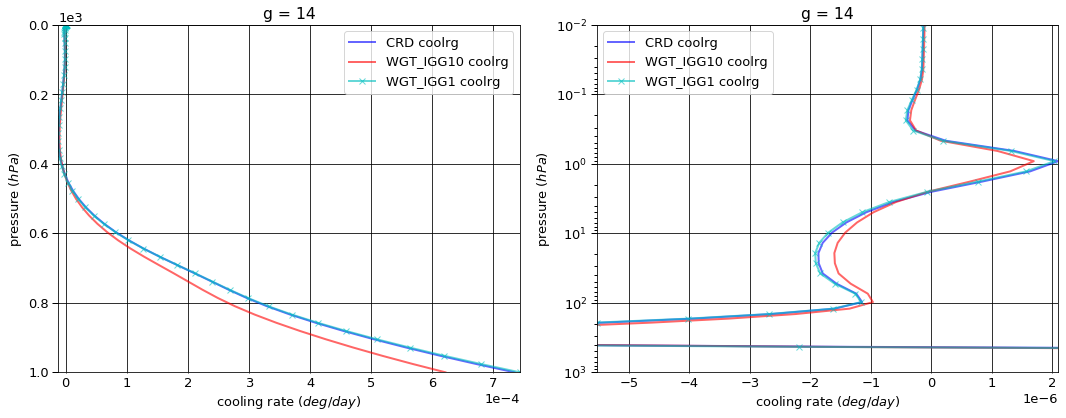

# Figure: cooling rate g-group 15

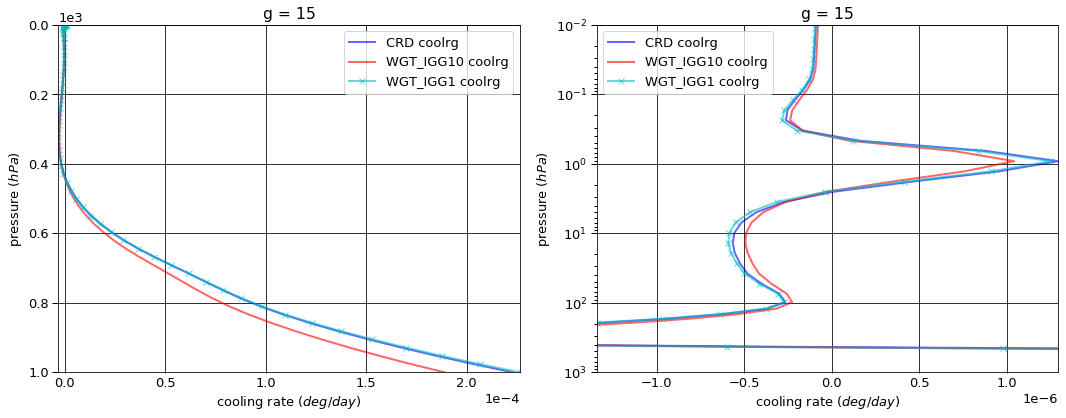

# Figure: cooling rate g-group 16

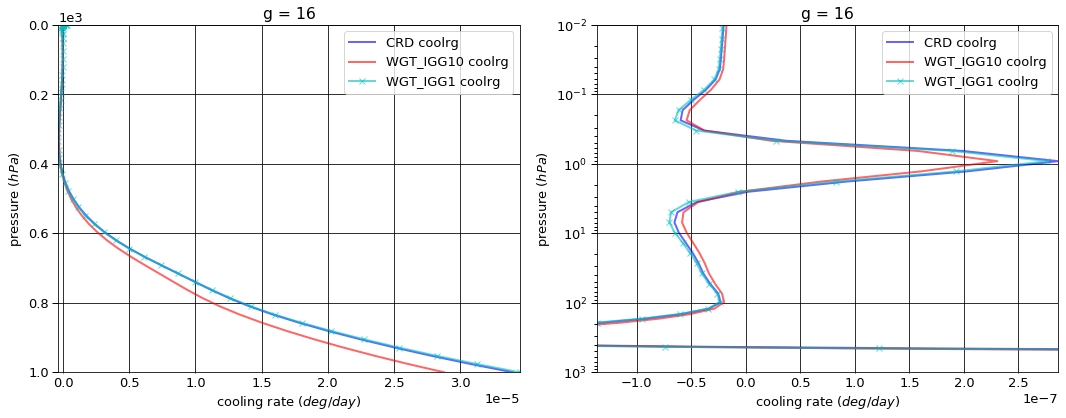

# Figure: cooling rate g-group total

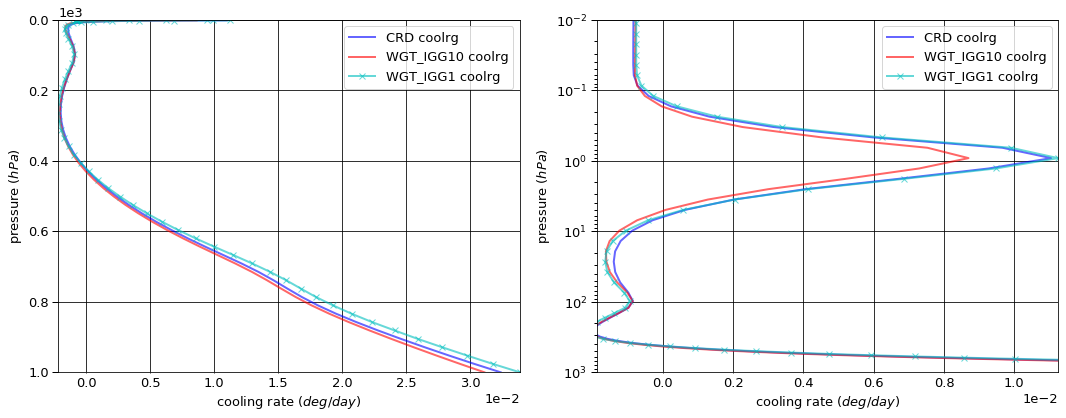

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg      fnetg
g  pressure level                                
1  0.0      1      -0.017368  0.000000  -0.017368
   1013.0   76     -0.027265  0.012300  -0.014965
2  0.0      1      -0.019190  0.000000  -0.019190
   1013.0   76     -0.024993  0.007654  -0.017339
3  0.0      1      -0.011650  0.000000  -0.011650
   1013.0   76     -0.015842  0.005568  -0.010274
4  0.0      1      -0.098708  0.000000  -0.098708
   1013.0   76     -0.108650  0.015231  -0.093419
5  0.0      1      -0.198051  0.000000  -0.198051
   1013.0   76     -0.218074  0.033049  -0.185025
6  0.0      1      -0.335384  0.000000  -0.335384
   1013.0   76     -0.367853  0.058089  -0.309764
7  0.0      1      -0.582802  0.000000  -0.582802
   1013.0   76     -0.634006  0.100590  -0.533416
8  0.0      1      -1.108972  0.000000  -1.108972
   1013.0   76     -1.181692  0.164730  -1.016961
9  0.0      1      -1.066614  0.000000  -1.066614
   1013.0   76     -1.164005  0.268934  -0.895071
10 0.0      1      -2.488326  0.000000  -2.488326
   1013.0   76     -2.568043  0.265527  -2.302516
11 0.0      1      -5.764076  0.000000  -5.764076
   1013.0   76     -5.823384  0.215930  -5.607454
12 0.0      1     -14.976601  0.000000 -14.976601
   1013.0   76    -15.028537  0.196075 -14.832461
13 0.0      1     -12.334280  0.000000 -12.334280
   1013.0   76    -12.348917  0.059789 -12.289129
14 0.0      1     -12.932386  0.000000 -12.932386
   1013.0   76    -12.937579  0.023164 -12.914415
15 0.0      1     -10.914147  0.000000 -10.914147
   1013.0   76    -10.915603  0.006815 -10.908788
16 0.0      1      -3.984810  0.000000  -3.984810
   1013.0   76     -3.985007  0.000986  -3.984021


WGT_IGG10


flug      fldg      fnetg
g  pressure level                                
1  0.0      1      -0.016963  0.000000  -0.016963
   1013.0   76     -0.026946  0.012406  -0.014540
2  0.0      1      -0.018553  0.000000  -0.018553
   1013.0   76     -0.024345  0.007783  -0.016562
3  0.0      1      -0.011227  0.000000  -0.011227
   1013.0   76     -0.015328  0.005803  -0.009525
4  0.0      1      -0.097192  0.000000  -0.097192
   1013.0   76     -0.107616  0.017064  -0.090552
5  0.0      1      -0.196378  0.000000  -0.196378
   1013.0   76     -0.217886  0.038104  -0.179782
6  0.0      1      -0.331913  0.000000  -0.331913
   1013.0   76     -0.366137  0.066508  -0.299629
7  0.0      1      -0.574902  0.000000  -0.574902
   1013.0   76     -0.627042  0.112087  -0.514956
8  0.0      1      -1.104909  0.000000  -1.104909
   1013.0   76     -1.176744  0.178454  -0.998290
9  0.0      1      -1.048592  0.000000  -1.048592
   1013.0   76     -1.134221  0.251691  -0.882529
10 0.0      1      -2.448799  0.000000  -2.448799
   1013.0   76     -2.516371  0.235780  -2.280591
11 0.0      1      -5.647039  0.000000  -5.647039
   1013.0   76     -5.695610  0.183529  -5.512080
12 0.0      1     -14.765494  0.000000 -14.765494
   1013.0   76    -14.807732  0.163737 -14.643995
13 0.0      1     -12.392231  0.000000 -12.392231
   1013.0   76    -12.404569  0.050272 -12.354297
14 0.0      1     -13.085026  0.000000 -13.085026
   1013.0   76    -13.089450  0.019531 -13.069919
15 0.0      1     -11.089842  0.000000 -11.089842
   1013.0   76    -11.091097  0.005760 -11.085337
16 0.0      1      -4.048187  0.000000  -4.048187
   1013.0   76     -4.048357  0.000833  -4.047524


WGT_IGG1


flug      fldg      fnetg
g  pressure level                                
1  0.0      1      -0.017198  0.000000  -0.017198
   1013.0   76     -0.026946  0.012342  -0.014604
2  0.0      1      -0.018422  0.000000  -0.018422
   1013.0   76     -0.024345  0.007969  -0.016376
3  0.0      1      -0.011143  0.000000  -0.011143
   1013.0   76     -0.015328  0.005870  -0.009458
4  0.0      1      -0.096193  0.000000  -0.096193
   1013.0   76     -0.107616  0.018445  -0.089171
5  0.0      1      -0.194353  0.000000  -0.194353
   1013.0   76     -0.217886  0.040954  -0.176931
6  0.0      1      -0.328662  0.000000  -0.328662
   1013.0   76     -0.366137  0.071328  -0.294809
7  0.0      1      -0.569762  0.000000  -0.569762
   1013.0   76     -0.627042  0.120394  -0.506648
8  0.0      1      -1.096885  0.000000  -1.096885
   1013.0   76     -1.176744  0.193902  -0.982842
9  0.0      1      -1.040651  0.000000  -1.040651
   1013.0   76     -1.134221  0.266729  -0.867491
10 0.0      1      -2.439221  0.000000  -2.439221
   1013.0   76     -2.516371  0.263628  -2.252743
11 0.0      1      -5.638533  0.000000  -5.638533
   1013.0   76     -5.695610  0.213324  -5.482285
12 0.0      1     -14.757426  0.000000 -14.757426
   1013.0   76    -14.807732  0.194248 -14.613485
13 0.0      1     -12.389813  0.000000 -12.389813
   1013.0   76    -12.404569  0.060039 -12.344530
14 0.0      1     -13.084151  0.000000 -13.084151
   1013.0   76    -13.089450  0.023381 -13.066068
15 0.0      1     -11.089593  0.000000 -11.089593
   1013.0   76    -11.091097  0.006902 -11.084195
16 0.0      1      -4.048153  0.000000  -4.048153
   1013.0   76     -4.048357  0.000998  -4.047359


WGT_IGG10 - CRD


flug      fldg     fnetg
g  pressure level                              
1  0.0      1      0.000405  0.000000  0.000405
   1013.0   76     0.000319  0.000106  0.000425
2  0.0      1      0.000637  0.000000  0.000637
   1013.0   76     0.000648  0.000129  0.000777
3  0.0      1      0.000423  0.000000  0.000423
   1013.0   76     0.000515  0.000234  0.000749
4  0.0      1      0.001516  0.000000  0.001516
   1013.0   76     0.001034  0.001833  0.002867
5  0.0      1      0.001673  0.000000  0.001673
   1013.0   76     0.000188  0.005055  0.005243
6  0.0      1      0.003472  0.000000  0.003472
   1013.0   76     0.001716  0.008419  0.010135
7  0.0      1      0.007900  0.000000  0.007900
   1013.0   76     0.006964  0.011497  0.018460
8  0.0      1      0.004063  0.000000  0.004063
   1013.0   76     0.004948  0.013723  0.018671
9  0.0      1      0.018021  0.000000  0.018021
   1013.0   76     0.029785 -0.017243  0.012542
10 0.0      1      0.039527  0.000000  0.039527
   1013.0   76     0.051673 -0.029747  0.021925
11 0.0      1      0.117037  0.000000  0.117037
   1013.0   76     0.127775 -0.032401  0.095373
12 0.0      1      0.211107  0.000000  0.211107
   1013.0   76     0.220805 -0.032338  0.188466
13 0.0      1     -0.057951  0.000000 -0.057951
   1013.0   76    -0.055652 -0.009517 -0.065168
14 0.0      1     -0.152640  0.000000 -0.152640
   1013.0   76    -0.151871 -0.003633 -0.155504
15 0.0      1     -0.175695  0.000000 -0.175695
   1013.0   76    -0.175494 -0.001055 -0.176549
16 0.0      1     -0.063378  0.000000 -0.063378
   1013.0   76    -0.063350 -0.000153 -0.063503


WGT_IGG1 - CRD


flug      fldg     fnetg
g  pressure level                              
1  0.0      1      0.000170  0.000000  0.000170
   1013.0   76     0.000319  0.000042  0.000361
2  0.0      1      0.000768  0.000000  0.000768
   1013.0   76     0.000648  0.000315  0.000963
3  0.0      1      0.000507  0.000000  0.000507
   1013.0   76     0.000515  0.000302  0.000816
4  0.0      1      0.002515  0.000000  0.002515
   1013.0   76     0.001034  0.003214  0.004248
5  0.0      1      0.003698  0.000000  0.003698
   1013.0   76     0.000188  0.007906  0.008094
6  0.0      1      0.006722  0.000000  0.006722
   1013.0   76     0.001716  0.013239  0.014955
7  0.0      1      0.013040  0.000000  0.013040
   1013.0   76     0.006964  0.019804  0.026767
8  0.0      1      0.012087  0.000000  0.012087
   1013.0   76     0.004948  0.029172  0.034119
9  0.0      1      0.025963  0.000000  0.025963
   1013.0   76     0.029785 -0.002204  0.027580
10 0.0      1      0.049105  0.000000  0.049105
   1013.0   76     0.051673 -0.001900  0.049773
11 0.0      1      0.125543  0.000000  0.125543
   1013.0   76     0.127775 -0.002606  0.125169
12 0.0      1      0.219175  0.000000  0.219175
   1013.0   76     0.220805 -0.001828  0.218976
13 0.0      1     -0.055533  0.000000 -0.055533
   1013.0   76    -0.055652  0.000250 -0.055401
14 0.0      1     -0.151765  0.000000 -0.151765
   1013.0   76    -0.151871  0.000218 -0.151653
15 0.0      1     -0.175446  0.000000 -0.175446
   1013.0   76    -0.175494  0.000087 -0.175407
16 0.0      1     -0.063344  0.000000 -0.063344
   1013.0   76    -0.063350  0.000012 -0.063338

# Table: cooling rate. g-groups 


CRD


coolrg
g  pressure    layer              
1  0.000312    1     -5.482997e-04
   1001.112500 75     1.379010e-04
2  0.000312    1     -1.591816e-04
   1001.112500 75     9.611608e-05
3  0.000312    1     -8.988052e-06
   1001.112500 75     7.081559e-05
4  0.000312    1     -4.585823e-05
   1001.112500 75     2.252938e-04
5  0.000312    1     -1.928393e-05
   1001.112500 75     4.822685e-04
6  0.000312    1     -8.121418e-06
   1001.112500 75     8.595850e-04
7  0.000312    1     -2.783601e-06
   1001.112500 75     1.540818e-03
8  0.000312    1     -1.050497e-06
   1001.112500 75     2.746964e-03
9  0.000312    1     -3.440335e-09
   1001.112500 75     5.314580e-03
10 0.000312    1     -1.159387e-08
   1001.112500 75     6.509869e-03
11 0.000312    1     -5.349632e-08
   1001.112500 75     5.948106e-03
12 0.000312    1     -1.296880e-07
   1001.112500 75     5.656900e-03
13 0.000312    1     -1.319215e-07
   1001.112500 75     1.788277e-03
14 0.000312    1     -9.714595e-08
   1001.112500 75     7.343311e-04
15 0.000312    1     -6.738975e-08
   1001.112500 75     2.229254e-04
16 0.000312    1     -1.523234e-08
   1001.112500 75     3.399412e-05


WGT_IGG10


coolrg
g  pressure    layer              
1  0.000312    1     -5.048599e-04
   1001.112500 75     1.396131e-04
2  0.000312    1     -1.507240e-04
   1001.112500 75     1.027177e-04
3  0.000312    1     -7.640112e-06
   1001.112500 75     7.774585e-05
4  0.000312    1     -3.550156e-05
   1001.112500 75     2.777622e-04
5  0.000312    1     -1.488147e-05
   1001.112500 75     6.274509e-04
6  0.000312    1     -6.257533e-06
   1001.112500 75     1.112901e-03
7  0.000312    1     -2.100536e-06
   1001.112500 75     1.938754e-03
8  0.000312    1     -8.535364e-07
   1001.112500 75     3.359189e-03
9  0.000312    1     -2.782889e-09
   1001.112500 75     5.220912e-03
10 0.000312    1     -9.948754e-09
   1001.112500 75     5.988472e-03
11 0.000312    1     -4.306123e-08
   1001.112500 75     5.147507e-03
12 0.000312    1     -1.080734e-07
   1001.112500 75     4.754711e-03
13 0.000312    1     -1.080734e-07
   1001.112500 75     1.510346e-03
14 0.000312    1     -8.261608e-08
   1001.112500 75     6.213909e-04
15 0.000312    1     -5.879191e-08
   1001.112500 75     1.890676e-04
16 0.000312    1     -1.317294e-08
   1001.112500 75     2.880818e-05


WGT_IGG1


coolrg
g  pressure    layer              
1  0.000312    1     -5.112092e-04
   1001.112500 75     1.342095e-04
2  0.000312    1     -1.465953e-04
   1001.112500 75     1.008010e-04
3  0.000312    1     -7.048366e-06
   1001.112500 75     7.507438e-05
4  0.000312    1     -3.687126e-05
   1001.112500 75     2.871172e-04
5  0.000312    1     -1.531675e-05
   1001.112500 75     6.459197e-04
6  0.000312    1     -6.502529e-06
   1001.112500 75     1.140925e-03
7  0.000312    1     -2.214222e-06
   1001.112500 75     1.986796e-03
8  0.000312    1     -9.258405e-07
   1001.112500 75     3.488326e-03
9  0.000312    1     -2.990030e-09
   1001.112500 75     5.242560e-03
10 0.000312    1     -1.133569e-08
   1001.112500 75     6.460305e-03
11 0.000312    1     -5.055432e-08
   1001.112500 75     5.903322e-03
12 0.000312    1     -1.286553e-07
   1001.112500 75     5.595472e-03
13 0.000312    1     -1.292798e-07
   1001.112500 75     1.798610e-03
14 0.000312    1     -9.875504e-08
   1001.112500 75     7.431182e-04
15 0.000312    1     -7.043982e-08
   1001.112500 75     2.264630e-04
16 0.000312    1     -1.575469e-08
   1001.112500 75     3.452367e-05


WGT_IGG10 - CRD


coolrg
g  pressure    layer              
1  0.000312    1      4.343983e-05
   1001.112500 75     1.712130e-06
2  0.000312    1      8.457650e-06
   1001.112500 75     6.601607e-06
3  0.000312    1      1.347941e-06
   1001.112500 75     6.930257e-06
4  0.000312    1      1.035667e-05
   1001.112500 75     5.246841e-05
5  0.000312    1      4.402466e-06
   1001.112500 75     1.451824e-04
6  0.000312    1      1.863885e-06
   1001.112500 75     2.533160e-04
7  0.000312    1      6.830642e-07
   1001.112500 75     3.979359e-04
8  0.000312    1      1.969607e-07
   1001.112500 75     6.122240e-04
9  0.000312    1      6.574463e-10
   1001.112500 75    -9.366810e-05
10 0.000312    1      1.645116e-09
   1001.112500 75    -5.213971e-04
11 0.000312    1      1.043508e-08
   1001.112500 75    -8.005987e-04
12 0.000312    1      2.161467e-08
   1001.112500 75    -9.021886e-04
13 0.000312    1      2.384818e-08
   1001.112500 75    -2.779317e-04
14 0.000312    1      1.452986e-08
   1001.112500 75    -1.129402e-04
15 0.000312    1      8.597836e-09
   1001.112500 75    -3.385782e-05
16 0.000312    1      2.059398e-09
   1001.112500 75    -5.185942e-06


WGT_IGG1 - CRD


coolrg
g  pressure    layer              
1  0.000312    1      3.709049e-05
   1001.112500 75    -3.691440e-06
2  0.000312    1      1.258637e-05
   1001.112500 75     4.684917e-06
3  0.000312    1      1.939686e-06
   1001.112500 75     4.258781e-06
4  0.000312    1      8.986972e-06
   1001.112500 75     6.182339e-05
5  0.000312    1      3.967187e-06
   1001.112500 75     1.636512e-04
6  0.000312    1      1.618889e-06
   1001.112500 75     2.813397e-04
7  0.000312    1      5.693785e-07
   1001.112500 75     4.459779e-04
8  0.000312    1      1.246566e-07
   1001.112500 75     7.413611e-04
9  0.000312    1      4.503057e-10
   1001.112500 75    -7.202050e-05
10 0.000312    1      2.581750e-10
   1001.112500 75    -4.956390e-05
11 0.000312    1      2.941997e-09
   1001.112500 75    -4.478380e-05
12 0.000312    1      1.032700e-09
   1001.112500 75    -6.142740e-05
13 0.000312    1      2.641790e-09
   1001.112500 75     1.033200e-05
14 0.000312    1     -1.609092e-09
   1001.112500 75     8.787140e-06
15 0.000312    1     -3.050071e-09
   1001.112500 75     3.537660e-06
16 0.000312    1     -5.223550e-10
   1001.112500 75     5.295440e-07

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-66.833365,0.000000,-66.833365
1013.0,76,-67.349451,1.434432,-65.915018



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-66.877246,0.000000,-66.877246
1013.0,76,-67.349450,1.349342,-66.000108



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-66.82016,0.000000,-66.820160
1013.0,76,-67.34945,1.500454,-65.848996



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-4.388166e-02,0.00000,-0.043882
1013.0,76,1.670000e-07,-0.08509,-0.085089



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,1.320507e-02,0.000000,0.013205
1013.0,76,1.670000e-07,0.066022,0.066022


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000794
1001.112500,75,0.032369



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.000723
1001.112500,75,0.031097



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.000727
1001.112500,75,0.033864



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000071
1001.112500,75,-0.001271



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000067
1001.112500,75,0.001495


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000417,0.000400
2,0.000389,0.000361
3,0.000250,0.000228
4,0.001639,0.001598
5,0.003250,0.003235
6,0.005528,0.005436
7,0.009611,0.009310
8,0.017722,0.017472
9,0.018167,0.016841


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.022092e-21
2,2.820805e-22
3,7.784951e-23
4,2.148517e-23
5,5.929548e-24
6,1.636456e-24
7,4.516347e-25
8,1.246437e-25
9,9.122916e-24


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.022092e-21,NaN,0.000417,0.000400,0.000417,0.000400,1.0
2,2.820805e-22,0.275983,0.000389,0.000361,0.000806,0.000762,1.0
3,7.784951e-23,0.275983,0.000250,0.000228,0.001056,0.000989,1.0
4,2.148517e-23,0.275983,0.001639,0.001598,0.002694,0.002587,1.0
5,5.929548e-24,0.275983,0.003250,0.003235,0.005944,0.005822,1.0
6,1.636456e-24,0.275983,0.005528,0.005436,0.011472,0.011259,1.0
7,4.516347e-25,0.275983,0.009611,0.009310,0.021083,0.020569,1.0
8,1.246437e-25,0.275983,0.017722,0.017472,0.038806,0.038041,1.0
9,9.122916e-24,73.191978,0.018167,0.016841,0.056972,0.054882,500.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
